# Rider Retention Prediction - Continued 

In this notebook we will be preprocessing and modeling our data. Our goal is to envoke various classification algorithms and generate the highest accuracy score possible for prediction rider retention (whether a user is considered 'active').

In [2]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math 

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset 

df_numeric = pd.read_csv('cleaned_rider_data.csv')

In [4]:
# drop date columns, resulting in a dataset with strictly numeric datatypes (float or int)

df_numeric.drop(['signup_date', 'last_trip_date', 'Unnamed: 0'], axis=1, inplace=True)

# Preprocessing

In [5]:
# import preprocessing library and various tools 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV

In [6]:
# break off the dependent 'target' variable from the independent 'predictor' varibales 

X_independents = df_numeric.drop(['active'], axis=1)
y_target = df_numeric.active

In [7]:
# train/test split the data 

X_train, X_test, y_train, y_test = train_test_split(X_independents, y_target, test_size=.20, random_state=22)

The plan here is to implement a handful of classification models and compare the results. We will explore Logistic Regression, Random Forest, and Gradient Boosting.

# Modeling with Logistic Regression


In [12]:
# import logistic regression algorithm 

from sklearn.linear_model import LogisticRegression

In [13]:
# create pipeline / instantiate model

lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

In [14]:
# Parameter tuning / Cross validation with Random search

# parameter options 
param_grid = {"lr__C" : [0.001, 0.01, 0.1, 0.5, 1, 1.5, 3, 5, 7, 10, 50],
             "lr__penalty" : ['l2', 'none'], 
             "lr__solver" : ['saga', 'lbfgs', 'newton-cg'], 
             "lr__class_weight": [None, 'balanced']}

# cross validate and tune 
lr_rscv = RandomizedSearchCV(lr_pipe, param_grid, cv=5, n_jobs=-1)

# fit model to training set
lr_rscv.fit(X_train, y_train)

# show best parameters  
print("best parameters: ", lr_rscv.best_params_)

# predict class for X
y_pred = lr_rscv.best_estimator_.predict(X_test)

best parameters:  {'lr__solver': 'lbfgs', 'lr__penalty': 'l2', 'lr__class_weight': None, 'lr__C': 0.5}


Accuracy Score = 0.728
F1 Score = 0.581
Precision = 0.686
Recall = 0.504


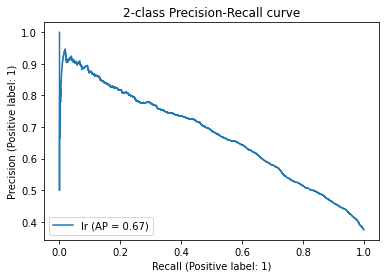

In [15]:
# create function that prints evaluation metrics

def evaluate(y__test, y__pred, model_obj, model_name):
    ac = accuracy_score(y__test, y__pred)
    f1 = f1_score(y__test, y__pred, average='binary')
    pr = precision_score(y__test, y__pred, average='binary')
    re = recall_score(y__test, y__pred, average='binary')

    print('Accuracy Score = %.3f' % (ac))
    print('F1 Score = %.3f' % (f1))
    print("Precision = {}".format(round(pr, 3)))
    print("Recall = {}".format(round(re, 3)))

    display = PrecisionRecallDisplay.from_estimator(model_obj, X_test, y_test, name=model_name)
    _ = display.ax_.set_title("2-class Precision-Recall curve")

# generate evaulation metrics
evaluate(y_test, y_pred, lr_rscv, 'lr')

Accuracy Score = 0.728
F1 Score = 0.581
Precision = 0.686
Recall = 0.504


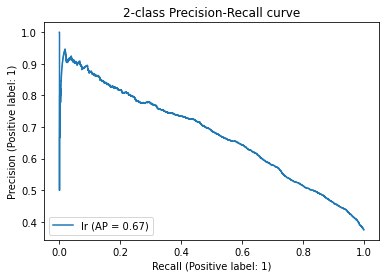

In [235]:
# Bayesian Hyperparameter tuning / Cross validation

# parameter options 
parameters = {"lr__C" : [0.001, 0.01, 0.1, 0.5, 1, 1.5, 3, 5, 7, 10, 50],
             "lr__penalty" : ['l2', 'none'], 
             "lr__solver" : ['saga', 'lbfgs', 'newton-cg'], 
             "lr__class_weight": [None, 'balanced']}

# cross validate and tune 
lr_opt = BayesSearchCV(lr_pipe, parameters,
         n_iter=32, random_state=0, return_train_score=True, cv=5)

# fit model to training set 
lr_opt.fit(X_train, y_train)

# predict class for X
y_pred = lr_opt.best_estimator_.predict(X_test)

# generate evaulation metrics
evaluate(y_test, y_pred, lr_opt, 'lr')


The Random Search and Bayesian Optimization parameter tuning techniques gave comparable results. The accuracy is 72.8%, which is decent. The dataset is mildly imbalanced so we must interpret 'accuracy' with a grain of salt. Our average precision is 67% which is decent. Of all the users we predict to be active, 67% of them actually are.

 Let's take a look at the coefficients to see which features are most predictive of our target variable. 

In [241]:
# access and rank the coefficients for our independent variables 

pipe_steps = lr_opt.best_estimator_.named_steps['lr']
df_coef = pd.DataFrame(zip(list(df_numeric.columns[:-1]),pipe_steps.coef_[0]),index=range(df_numeric.columns[:-1].shape[0]),columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)

,feature,coefficient
0,trips_in_first_30_days,0.444714
9,city_King's Landing,0.425985
4,ultimate_black_user,0.421705
13,phone_iPhone,0.246778
3,surge_pct,0.077042
5,weekday_pct,-0.003666
12,phone_Unknown,-0.006277
2,avg_surge,-0.029107
1,avg_rating_of_driver,-0.042486
10,city_Winterfell,-0.058091


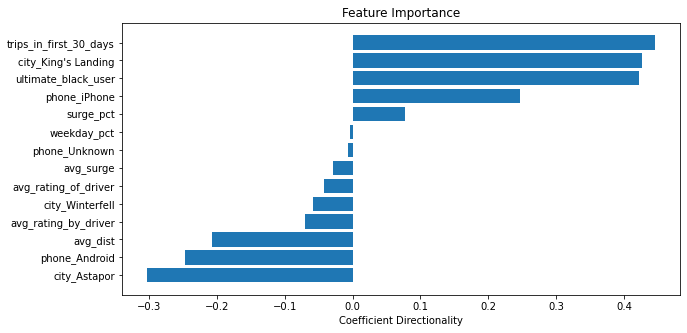

In [242]:
# plot feature importance scores(coefficients), ordered by importance

scores_ = np.array(pipe_steps.coef_[0])
sorted_idx = np.argsort(scores_)

# make plots 
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(10,5))
plt.barh(pos, scores_[sorted_idx], align='center')
plt.yticks(pos, df_numeric.columns[sorted_idx])
plt.xlabel('Coefficient Directionality')
plt.title('Feature Importance')
plt.show()

According to our logistic regression model we can see that 'trips in first 30 days', 'city King's Landing', and 'ultimate black user' are highly and positively correlated with a user being retained (or 'active'). 'iPhone user' and 'surge percent' are also positively correlated but to a lesser degree. 'city Astapor', 'Andriod user' and 'average distance' are all negatively correlated with retention. 

# Modeling with Random Forest Classifier 

In [222]:
# import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import permutation feature importance function 
from sklearn.inspection import permutation_importance

In [223]:
# create pipeline / instantiate model 

rfc_pipe = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier())])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'rfc__n_estimators': 500, 'rfc__min_samples_split': 5, 'rfc__min_samples_leaf': 4, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 60, 'rfc__bootstrap': True}
Training accuracy score from tuned model: 78.3%

Accuracy Score = 0.790
F1 Score = 0.699
Precision = 0.754
Recall = 0.652


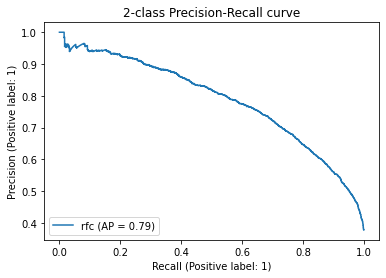

In [229]:
# Parameter tuning / Cross validation with Random search

# parameter options
parameters = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 15, 20, 25, 30],
        'rfc__max_features': ['auto', 'sqrt'],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [25, 50, 75, 100, 150]}

# cross validate and tune 
rfc_rscv = RandomizedSearchCV(rfc_pipe, param_distributions=parameters, cv=5, verbose=True, random_state=13)

# fit model to training set 
rfc_rscv.fit(X_train, y_train)

# show best parameters  
print(f'Best parameters: {rfc_rscv.best_params_}')
print(f'Training accuracy score from tuned model: {rfc_rscv.best_score_*100:.1f}%')
print('')

# predict class for X
y_pred = rfc_rscv.predict(X_test)

# generate evaulation metrics
evaluate(y_test, y_pred, rfc_rscv, 'rfc')

Best parameters: OrderedDict([('rfc__bootstrap', True), ('rfc__max_depth', 15), ('rfc__max_features', 'sqrt'), ('rfc__min_samples_leaf', 9), ('rfc__min_samples_split', 15), ('rfc__n_estimators', 175)])

Accuracy Score = 0.787
F1 Score = 0.694
Precision = 0.754
Recall = 0.643


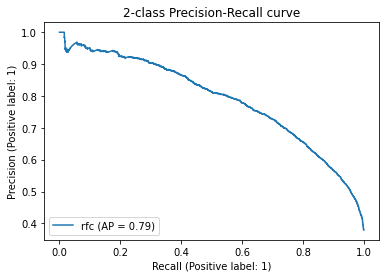

In [243]:
# Parameter tuning / Cross validation with Bayesian Optimization 

# parameter options  
parameters = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 15, 20, 25, 30],
        'rfc__max_features': ['auto', 'sqrt'],
        'rfc__min_samples_leaf': [3, 5, 7, 9],
        'rfc__min_samples_split': [2, 5, 7, 10, 15],
        'rfc__n_estimators': [25, 50, 75, 100, 150, 175]}

# cross validate and tune 
rfc_opt = BayesSearchCV(rfc_pipe, parameters,
          n_iter=32, return_train_score=True, cv=5) 

# fit model to training set
rfc_opt.fit(X_train, y_train)

# show best parameters  
print(f'Best parameters: {rfc_opt.best_params_}')
print('')

# predict class for X
y_pred = rfc_opt.predict(X_test)

# generate evaulation metrics
evaluate(y_test, y_pred, rfc_opt, 'rfc')


Random Search and Bayesian Optimization again gave similar scores for parameter tuning. Overall Random Forest is outperforming Logistic Regression. It has delivered an accuracy rate of 79% and an Average Precision of 79%. 

In [244]:
# create function for evaluating and plotting feature importance for Ensemble methods 

def feature_metrics(model_object, pipe_model_name, title, perm=False):

    # generate permutation feature importance if desired (perm=True)
    if perm == True:
        perm_imp = permutation_importance(model_object, X_train, y_train, n_repeats=10, random_state=22)
        mean_imp = [v for k,v in perm_imp.items() if k == 'importances_mean']
        feature_importance = mean_imp[0]

    # generate GINI importance metric
    else:
        feature_importance = model_object.best_estimator_.named_steps[pipe_model_name].feature_importances_

    # create list of feature name and importance score 
    rounded_feat = [round(x,2) for x in feature_importance]
    feat_imp = list(zip(df_numeric.columns[:-1],rounded_feat))

    # print list of features and their importance as a proportion of the total importance
    print('Features and their proportional importance:')
    for i in feat_imp:
        print(i[0], '=', int(i[1]*100), '%')
    
    # make plots
    sorted_idx = np.argsort(feature_importance) 
    pos = np.arange(sorted_idx.shape[0]) 
    sorted_idx.size
    plt.figure(figsize=(15,5))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df_numeric.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.show()

Features and their proportional importance:
trips_in_first_30_days = 7 %
avg_rating_of_driver = 4 %
avg_surge = 10 %
surge_pct = 13 %
ultimate_black_user = 6 %
weekday_pct = 12 %
avg_dist = 8 %
avg_rating_by_driver = 17 %
city_Astapor = 3 %
city_King's Landing = 10 %
city_Winterfell = 2 %
phone_Android = 4 %
phone_Unknown = 0 %
phone_iPhone = 4 %


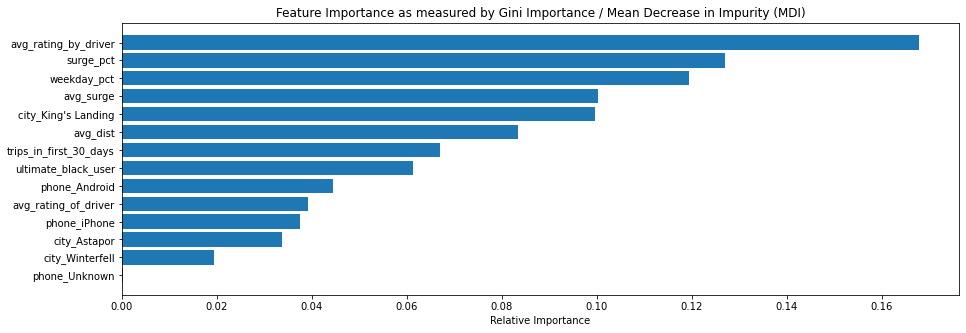

In [245]:
# GINI feature importance for Random Forest 

feature_metrics(rfc_opt, 'rfc', 'Feature Importance as measured by Gini Importance / Mean Decrease in Impurity (MDI)')

Features and their proportional importance:
trips_in_first_30_days = 2 %
avg_rating_of_driver = 1 %
avg_surge = 1 %
surge_pct = 2 %
ultimate_black_user = 3 %
weekday_pct = 4 %
avg_dist = 2 %
avg_rating_by_driver = 4 %
city_Astapor = 1 %
city_King's Landing = 4 %
city_Winterfell = 1 %
phone_Android = 1 %
phone_Unknown = 0 %
phone_iPhone = 1 %


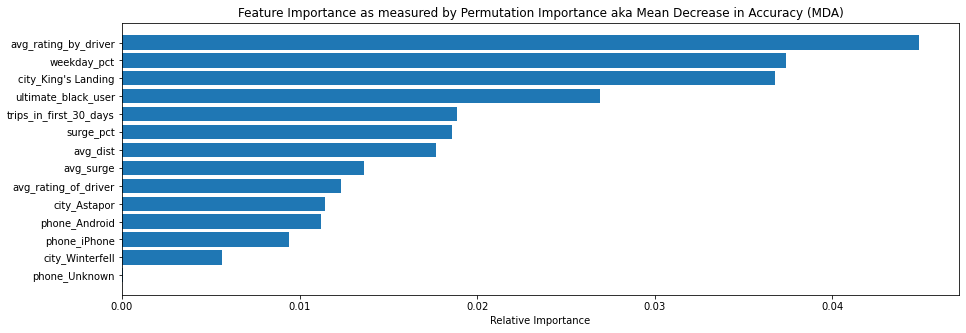

In [246]:
# Permutation feature importance for Random Forest 

feature_metrics(rfc_opt, 'rfc', 'Feature Importance as measured by Permutation Importance aka Mean Decrease in Accuracy (MDA)', perm=True)

Above we compared two methods of calculating feature importance. The default feature importance calculation in SkLearn is known as GINI or Mean Decrease in Impurity. This method has been shown to have some pitfalls as it has the potential to be skewed by features with high cardinality like numeric/continuous features. Because there are more unique values with continuous variables they end up being used more in decision trees and can thus take on more 'weight' when evaulating feature importance.

The permutation method can help provide another perspective on feature importance. It helps prevent the discounting of binary (low cardinalty) features when determining importance. 

We notice that both methods place 'average rating by driver' as the most important feature followed by 'percent of trips taken on weekdays'. However permutation importance lists 'King's Landing city' and 'ultimate black user' as the next two most important features. These are both binary (or categorical, 1 or 0) features, so this makes sense considering how permutation importance works. The GINI importance however lists 'surge percent' and 'average distance' as the third and forth most important features. This makes sense becuase they are both highly cardinal.

Overall both of these evaluations tell us 'average rating by driver' and 'percentage of trips on weekdays' are import features. Let's plot those two features below to see if we can visualize and relationship between the feature and our dependent variable.

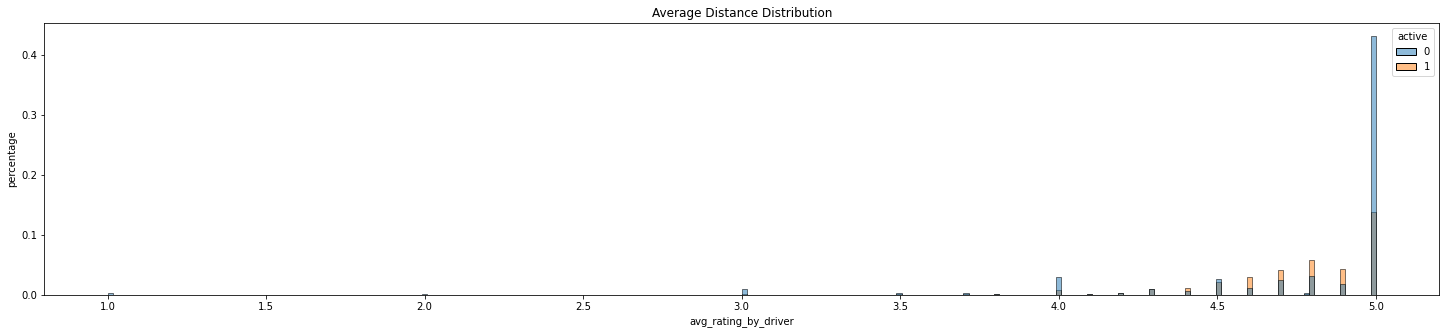

In [247]:
# plot the 'average rating by driver' distrubution of our dataset to see if we can spot a correltaion 

fig, ax = plt.subplots(figsize=(25,5))
ax = sns.histplot(x='avg_rating_by_driver', data=df_numeric, hue='active', stat = 'probability')
ax.set(xlabel= 'avg_rating_by_driver', ylabel= 'percentage', title='Average Distance Distribution')
plt.show()

There appears to be a *negative* correlation between rating by driver and retention. Our linear regression coefficients also reflected this. This could possibly be explained by .. the more someone rides the more likely they are to have a mishap or poor interaction with the driver. The vast majority of ratings are still above 3.0 which suggests there aren't many *horrible* interactions. 

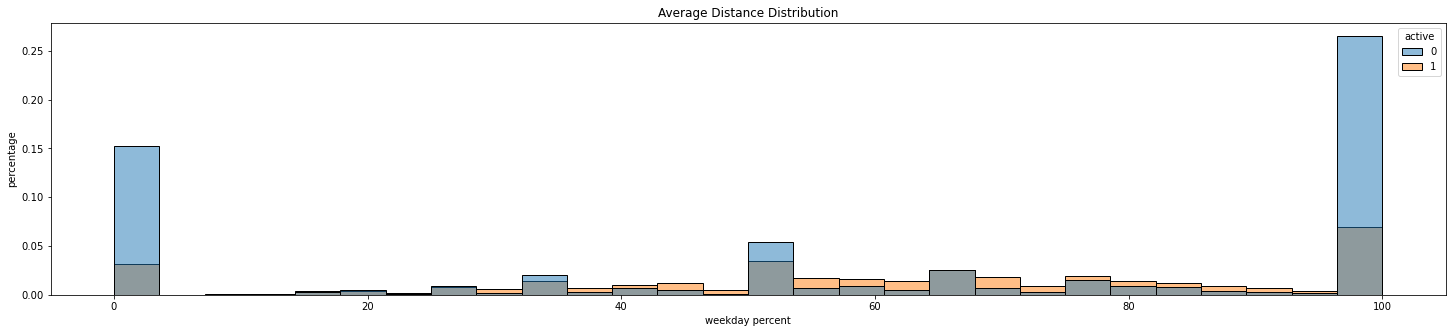

In [248]:
# plot the 'weekday_pct' distrubution of our dataset to see if we can spot a correltaion 

fig, ax = plt.subplots(figsize=(25,5))
ax = sns.histplot(x='weekday_pct', data=df_numeric, hue='active', stat = 'probability')
ax.set(xlabel= 'weekday percent', ylabel= 'percentage', title='Average Distance Distribution')
plt.show()

This plot is interesting. There appears to be a normal distribution amongst active users and the percentage of their trips that occur on weekdays. Perhaps this points to a relationship between regular usage of the service and retention. Inactive users are much more splot between either 0% or 100% of trips occuring during weekdays. 

# Modeling with Gradient Boosting 

In [8]:
# import XGBoost library 

import xgboost as xgb

In [9]:
# create pipeline / instantiate model 

boost_pipe = Pipeline([('scaler', StandardScaler()), ('xgclass', xgb.XGBClassifier())])

Best parameters: {'xgclass__min_child_weight': 5, 'xgclass__max_depth': 4, 'xgclass__learning_rate': 0.3, 'xgclass__gamma': 0.4, 'xgclass__eta': 0.25, 'xgclass__colsample_bytree': 0.3}
Best Score: 0.788825
 
Accuracy Score = 0.794
F1 Score = 0.707
Precision = 0.756
Recall = 0.664


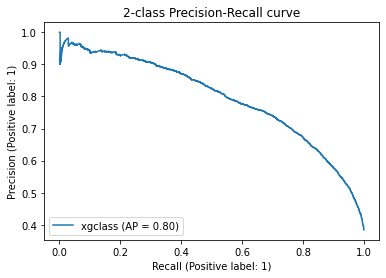

In [16]:
# Parameter tuning / Cross validation with Random search

# parameter options 
parameters = {
     "xgclass__eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "xgclass__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "xgclass__min_child_weight" : [ 1, 3, 5, 7 ],
     "xgclass__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "xgclass__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "xgclass__learning_rate": [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]}

# cross validate and tune 
boost_rscv = RandomizedSearchCV(boost_pipe,
                    parameters, n_jobs=-1,
                    scoring="accuracy",
                    cv=5)

# fit model to training set 
boost_rscv.fit(X_train, y_train)

# show best parameters 
print("Best parameters:", boost_rscv.best_params_)
print("Best Score:", boost_rscv.best_score_)
print(' ')

# predict class for X
y_pred = boost_rscv.predict(X_test)

# generate evaulation metrics
evaluate(y_test, y_pred, boost_rscv, 'xgclass')

Best parameters: OrderedDict([('xgclass__colsample_bytree', 0.7), ('xgclass__eta', 0.2), ('xgclass__gamma', 0.4), ('xgclass__max_depth', 5), ('xgclass__min_child_weight', 7)])
 
Accuracy Score = 0.795
F1 Score = 0.708
Precision = 0.758
Recall = 0.665


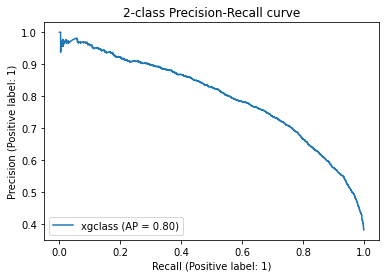

In [251]:
# Parameter tuning / Cross validation with Bayesian Optimization 

# parameter options 
parameters = {"xgclass__eta"    : [0.10, 0.15, 0.20, 0.25],
     "xgclass__max_depth"        : [ 4, 5, 6, 8],
     "xgclass__min_child_weight" : [ 1, 3, 5, 7 ],
     "xgclass__gamma"            : [ 0.1, 0.2 , 0.3, 0.4 ],
     "xgclass__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]}

# cross validate and tune 
xgb_opt = BayesSearchCV(boost_pipe, parameters, 
                        n_iter=50, return_train_score=True, cv=5)

# fit model to training set
xgb_opt.fit(X_train, y_train)

# show best parameters 
print("Best parameters:", xgb_opt.best_params_)
print(' ')

# predict class for X
y_pred = xgb_opt.predict(X_test)

# generate evaulation metrics
evaluate(y_test, y_pred, xgb_opt, 'xgclass')

Random Search and Bayesian Optimization again gave similar scores for parameter tuning. Gradient Boosting outperformed Random Forest by a small margin. It has delivered an accuracy rate of 79.5% and an Average Precision of 80%. Gradient Boosting is the model we would move forward with into production.  

Features and their proportional importance:
trips_in_first_30_days = 3 %
avg_rating_of_driver = 0 %
avg_surge = 9 %
surge_pct = 0 %
ultimate_black_user = 15 %
weekday_pct = 11 %
avg_dist = 0 %
avg_rating_by_driver = 9 %
city_Astapor = 5 %
city_King's Landing = 21 %
city_Winterfell = 3 %
phone_Android = 12 %
phone_Unknown = 0 %
phone_iPhone = 2 %


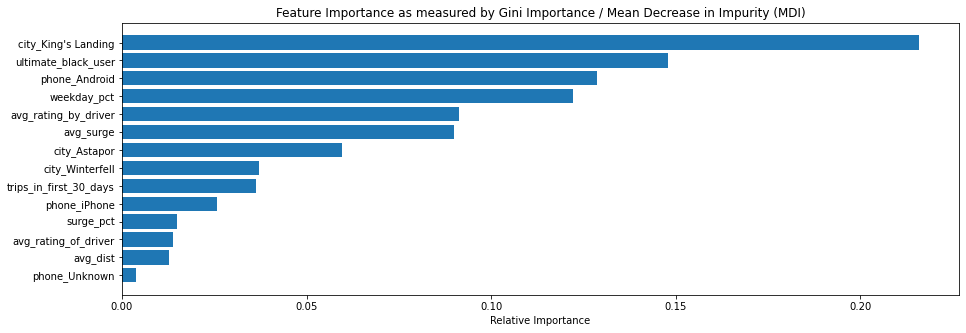

In [260]:
# GINI feature importance for Gradient Boosting

feature_metrics(boost_rscv, 'xgclass', 'Feature Importance as measured by Gini Importance / Mean Decrease in Impurity (MDI)')

Features and their proportional importance:
trips_in_first_30_days = 2 %
avg_rating_of_driver = 0 %
avg_surge = 2 %
surge_pct = 1 %
ultimate_black_user = 2 %
weekday_pct = 4 %
avg_dist = 1 %
avg_rating_by_driver = 3 %
city_Astapor = 1 %
city_King's Landing = 3 %
city_Winterfell = 0 %
phone_Android = 1 %
phone_Unknown = 0 %
phone_iPhone = 0 %


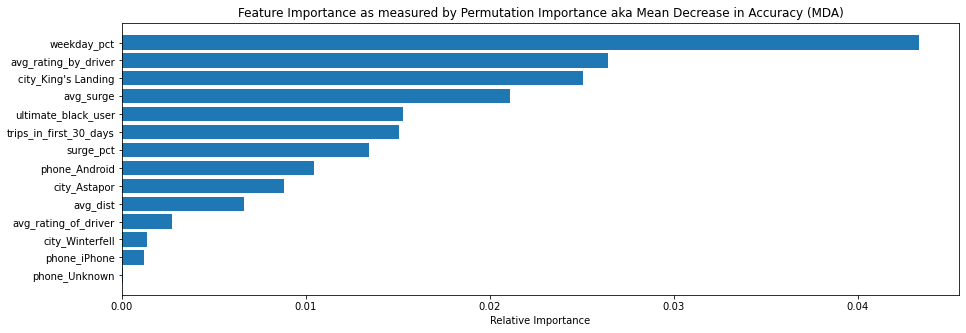

In [259]:
# Permutation feature importance for Gradient Boosting

feature_metrics(boost_rscv, 'xgclass', 'Feature Importance as measured by Permutation Importance aka Mean Decrease in Accuracy (MDA)', perm=True)

The GINI importance here favors 'King's Landing' by quite a decent margin. Followed by 'ultimate black user', 'Andriod user' and 'weekday percent'. 
Permutation Importance favors 'weekday percent', 'average rating by driver', 'King's Landing' and 'average surge'.

We can see that 'weekday percent' has shown up in the top 4 for both our Random Forest and our XGBoost models. This is intersting because the Logistic Regression coefficient indictated that this feature was pretty neutral in its predictive value. 

King's Landing as the city of residence is another feature that has continuously been identified as important. 



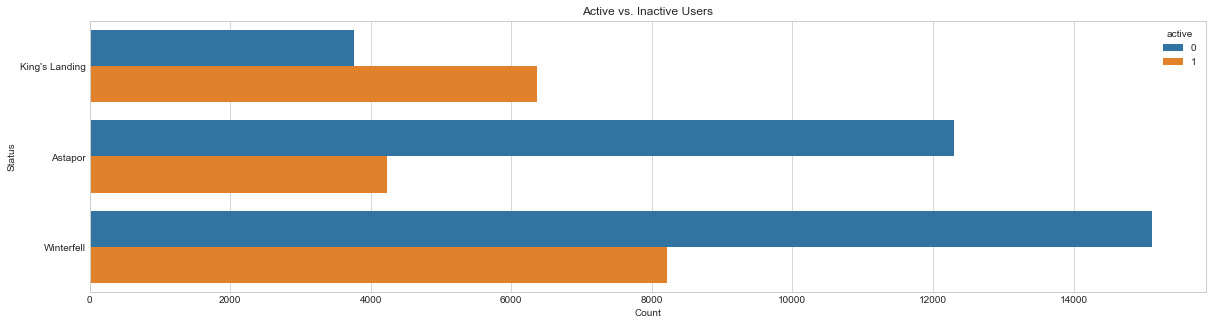

In [1573]:
# examine city columns 

df_with_city = pd.merge(df_numeric, df_user_info['city'], left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(y="city", data=df_with_city, hue="active")
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
plt.show()

We can see that there is a very disproportionate amount of active users in King's Landing! In the entire dataset there's aabout 38% active users and 62% inactive users, whereas for King's Landing there's siginificantly more active than inactive users. I would recommend the company look into this and see if we can figure out what's special about King's Landing. 

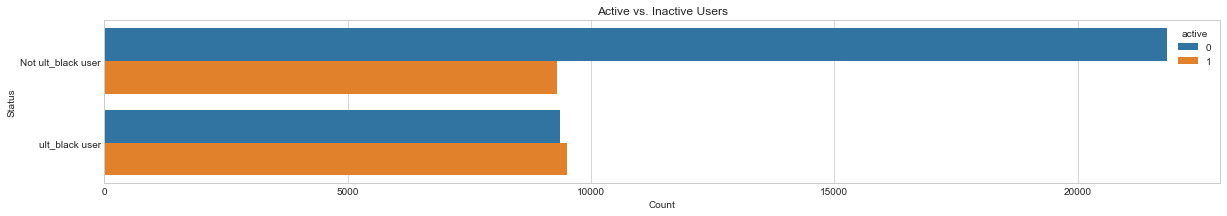

In [1580]:
fig, ax = plt.subplots(figsize=(20,3))
ax = sns.countplot(y="ultimate_black_user", data=df_with_city, hue="active")
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
ax.set_yticklabels(['Not ult_black user', 'ult_black user' ])
plt.show()

We can see that for people who are ultimate balck users about half of them are active and half aren't. For people who are not ultimate black users the proportion of active and inactive is more representative of the overall dataset. We can conclude that being an ultimate black user matters for predicting retention. 

In [1]:
# use the SHAP library to evaluate feature importance 

import shap

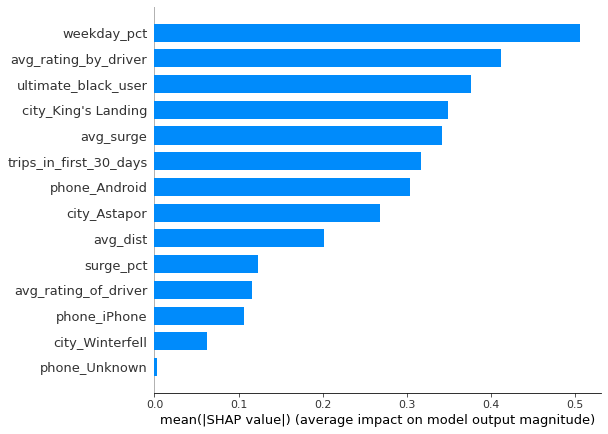

In [17]:
X_encoded = boost_rscv.best_estimator_['scaler'].fit_transform(X_train)

# fit the model 
best_model = boost_rscv.best_estimator_['xgclass'].fit(X_encoded, y_train)

# calculate the Shap values
shap_values = shap.TreeExplainer(best_model).shap_values(X_encoded)

# plot the Shap values
shap.summary_plot(shap_values, X_test, plot_type='bar')

Shaply Additive Explanations are an approach to feature importance that provides the average marginal contribution of a feature value across all the possible combinations of features. The Shapley value is the average of all the marginal contributions to all possible coalitions (groups of features). 

The Shapply values here place 'weekday_percent' atop the importance list followed by 'average rating by driver', with 'ultimate_black_user' and 'King's Landing city' coming in 3rd and forth. 

# Final Thoughts

Of all the models, Gradient Boosting produced the best results; achieving an accuracy score of 80%. Each model type produced variations on feature importance ranking, but there was some notable consistency:

**King's Landing**: If a user lives in King's Landing they are far more likely to be retained. I would recommend the company look into the characteristics of this city to try and discover why. Has Ultimate run some type of promotion there? Or does it have to do with the economic, geographic, or political nature of that city? Depending on what we can learn about these cities, the company might want to look into increasing marketing in King's Landing to see if there is more market share to grab. On the other hand, we could also consider increasing marketing spend in Winterfell and Astapor to attract new customers.

**Weekday Percent**: Users with a higher percent (but not 100%) of trips taken on weekdays were more likely to be retained. This could reveal a correlation between people using the service for commuting and/or regular activity and continued use. It makes sense that if people have a routine of using Ultimate, they will be retained. I would recommend that the company run marketing campaigns presenting the service as a viable means of regular commuting. Ultimate could potentially begin an initiative to offer discounts to people who start using it to commute with the hope of that person continuing regular use after the initial discount ends. 

**Ultimate Black User**: This feature correlates to people using Ultimate's 'premium' service in the first 30 days. I would suspect there is a correlation between wealth and the ability to use the premium service. This could potentially reveal a correlation between income level and retention. Ride services do tend to be on the expensive side compared to public transit, so maybe this correlation influces what 'class' of people Ultimate markets to in the future. 

**Surge Percent**: This feature tells us that riders with a higher avergage amount of trips with a surge multiplier greater than 1 are more likely to be retained. This feature falls in line with 'weekday percent' and could indicate that people who use the service at rush hour are most likely commuting and thus more likely to use the service as part of their routine. 

**Average Rating by Driver**: The feature is pretty interesting as it's negatively correlated with retention. I belive that this could point to a phenomenon where the more often someone takes a ride the more likely they are to have a (somewhat) negative encounter with a driver and thus receive a lower rating. Also, if we know that daily commuters are using the service, someone may be in a worse mood or less likely to want to engage in friendly conversation with a driver. Sidenote: The average ratings were still typically above 3, so not *horrible* ratings. 

All in all we garnered some great takeaways. I believe many of the insights are actionable and could lead to potentially lucrative experiments. 